# Predicting Restaurant Ratings

This notebook will combine the information about restaurants and the processed text from reviews and perform machine learning algorithms to make predictions about ratings based on the restaurants' features and reviews.
The analysis will focus on restaurants from Phoenix, Arizona, as this represents a compact data set with approx. 3,500 restaurants and just over 300,000 reviews about them. The analysis involves the following steps:
1. Importing the raw data from the _'business.json'_ file, filtering for restaurants in Phoenix, AZ, and converted to a pandas DataFrame format
2. Extracting features of each business for analysis
3. Importing the reviews from the _'review.json'_ file and converting each review to a vector, to be used with the already trained word2vec model
4. Sentiment modeling - this involves two parts: first, a training set of reviews will be used for supervised learning of the reviews' sentiment (positive or negative), using the star ratings as labels. Then the entiment will be predicted on a test set and its accuracy scored against the actual ratings. A variety of prediction models will be tested, including random forest and neural networks (MLPC).
5. Predicting actual star ratings based on the text of a review using a number of classifier models: random forest, ada boost and MLPC.
6. Visualising star rating predictions in 2-dimensional space, using t-SNE dimensionality reduction



# 1. Importing Restaurant  Data

In [1]:
import pandas as pd
import numpy as np
import json

In [2]:
# import raw data from json in the first run and save to .csv file
# for new runs load data directly from a .csv file to speed up the process 
if 0 == 1:
    businesses_df = pd.read_json('data/dataset/business.json', lines=True)
    businesses_df['restaurants'] = businesses_df['categories'].apply(lambda x: 'Restaurants' in x)
    restaurants_df = businesses_df[businesses_df['restaurants'] == True]
    restaurants_df.to_csv('data/restaurants.csv', encoding='utf-8')

else:
    restaurants_df = pd.read_csv('data/restaurants.csv', encoding='utf-8')

In [3]:
restaurants_df = restaurants_df.drop(['Unnamed: 0', 'restaurants'], axis=1)
restaurants_df.shape

(51613, 15)

In [4]:
restaurants_df.head(2)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,2824 Milton Rd,"{u'GoodForMeal': {u'dessert': False, u'latenig...",mLwM-h2YhXl2NCgdS84_Bw,"[Food, Soul Food, Convenience Stores, Restaura...",Charlotte,"{u'Monday': u'10:00-22:00', u'Tuesday': u'10:0...",0,35.236870,-80.741976,South Florida Style Chicken & Ribs,Eastland,28215,4,4.5,NC
1,4719 N 20Th St,"{u'GoodForMeal': {u'dessert': False, u'latenig...",duHFBe87uNSXImQmvBh87Q,"[Sandwiches, Restaurants]",Phoenix,{},0,33.505928,-112.038847,Blimpie,NaN,85016,10,4.5,AZ


In [5]:
restaurants_df.columns

Index([u'address', u'attributes', u'business_id', u'categories', u'city',
       u'hours', u'is_open', u'latitude', u'longitude', u'name',
       u'neighborhood', u'postal_code', u'review_count', u'stars', u'state'],
      dtype='object')

Data required is now loaded as restaurants_df data frame. The line below shows the structure of data by state - first Arizona (AZ) was selected as having a large data set of 10,000+ restaurants, and then Phoenix with 3,500+ restaurants. Choosing a single city with a wealth of data means that restaurants are comparable to each other and that meaningful conclusions can be drawn. However, the analysis can be easily expanded in scope to include other cities / states. Additionally, avoiding e.g. Quebec means that the analysis is limited to English language reviews.

In [6]:
by_state = restaurants_df.groupby('state')['stars'].count()
by_state.sort_values(ascending=False)[:10]

state
ON     12634
AZ     10219
NV      6883
QC      4567
OH      4513
NC      3625
PA      3435
BW      1759
WI      1486
EDH     1396
Name: stars, dtype: int64

In [7]:
by_state.shape

(36L,)

In [8]:
arizona = restaurants_df.loc[restaurants_df.state == 'AZ']
phoenix = arizona.loc[arizona.city == 'Phoenix']
phoenix.shape

(3515, 15)

In [9]:
# save id's as set for faster searching
phx_ids = set(phoenix.business_id)
type(phx_ids)

set

The Phoenix restaurants are contained in the 'phoenix' data frame and the related business id data is kept in the 'phx-ids' set to be used when loading reviews.

In [10]:
import matplotlib.pyplot as plt
% matplotlib inline

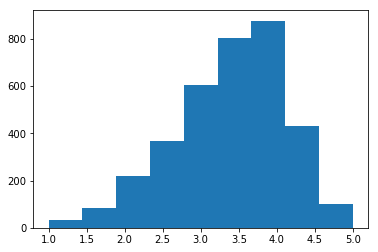

In [11]:
stars_rating = phoenix.stars
#log_stars = np.log(stars_rating)
plt.hist(phoenix.stars, bins=9)
plt.show()

In [12]:
phoenix.stars.value_counts().sort_index()

1.0     32
1.5     82
2.0    218
2.5    368
3.0    603
3.5    804
4.0    877
4.5    431
5.0    100
Name: stars, dtype: int64

In [13]:
phoenix.stars.mean()

3.437126600284495

In [14]:
high_ratings = phoenix.stars[phoenix.stars >= 4]
low_ratings = phoenix.stars[phoenix.stars <= 2]
print high_ratings.count() / 3515.0
print low_ratings.count() / 3515.0

0.400568990043
0.0944523470839


We now have a data set of 3,515 restaurants in Phoenix. The star ratings distribution has a positive skew, i.e. there are more positive than negative reviews, and the mean is approximately 3.4 stars.

# 2. Extracting Business Features 

The code below extracts data from the 'business.json' file and converts into a pandas data frame  using the json_normalize function. This will form the features matrix for machine learniong algorithms. Items such as parking, ambience and food choice are included. The json_normalize function extracts all the information in one step for each line of the json file. 

In [15]:
from pandas.io.json import json_normalize
import codecs
import os


In [16]:
%%time

# set the file path
business_json_filepath = os.path.abspath('data/dataset/business.json')

# initiate empty data frame
featuresdf = pd.DataFrame(zip([],[]))

# extract info line by line for each restaurant in the phx_ids set
with codecs.open(business_json_filepath, encoding='utf_8') as f:
    for line in f:
        business = json.loads(line)
        bus_id = business[u'business_id'] 
        if bus_id not in phx_ids:
            continue
        norm = json_normalize(business) 

        featuresdf = featuresdf.append(norm)
        

Wall time: 2min 10s


In [17]:
featuresdf.shape

(3515, 93)

In [18]:
featuresdf.head(2)

,address,attributes.AcceptsInsurance,attributes.AgesAllowed,attributes.Alcohol,attributes.Ambience.casual,attributes.Ambience.classy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.intimate,attributes.Ambience.romantic,...,hours.Wednesday,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,4719 N 20Th St,NaN,NaN,none,False,False,False,False,False,False,...,NaN,0,33.505928,-112.038847,Blimpie,,85016,10,4.5,AZ
0,"2641 N 44th St, Ste 100",NaN,NaN,none,True,False,False,False,False,False,...,10:00-22:00,1,33.478043,-111.986370,Five Guys,,85008,63,3.5,AZ


In [19]:
featuresdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3515 entries, 0 to 0
Data columns (total 93 columns):
address                                       3515 non-null object
attributes.AcceptsInsurance                   2 non-null object
attributes.AgesAllowed                        4 non-null object
attributes.Alcohol                            2977 non-null object
attributes.Ambience.casual                    2841 non-null object
attributes.Ambience.classy                    2841 non-null object
attributes.Ambience.divey                     2841 non-null object
attributes.Ambience.hipster                   2841 non-null object
attributes.Ambience.intimate                  2841 non-null object
attributes.Ambience.romantic                  2841 non-null object
attributes.Ambience.touristy                  2841 non-null object
attributes.Ambience.trendy                    2841 non-null object
attributes.Ambience.upscale                   2841 non-null object
attributes.BYOB                

The data includes 93 features and needs to be modified to produce a useful features matrix. First we need to drop columns:
- those that appear in only a handful of lines, such as 'attribuites.accepts_insurance' 
- opening hours need to be modified to a more meaningful format
- other categorical data need to be quantified
- neighborhood, city and state to be removed as the data set focuses on a single city (for Phoenix no neighbourhood data is given)
- name of business, stars rating and id to be removed

__Exploratory Data Analysis of the Features__:

In this section we will visualize some aspects of the data that look the most relevant to determining aveareg ratings. First of all it is important to note that there are many missing values: there are many features in the data set but an individual restaurant will only have a few of the features actually quoted, and the rest will be empty fiels. From the description of columns above, we can identify the more complete features:
- fully complete columns that we can use in the prediction model are the longitude/latitude and is_open binary feature
- relatively well-formed columns (say > 2,000 entries) relate to opening hours,  type of meals offered, price range, parking, ambiance, alcohol and some others. 

We can inspect if there is a significant correlation with ratings for some of these items:

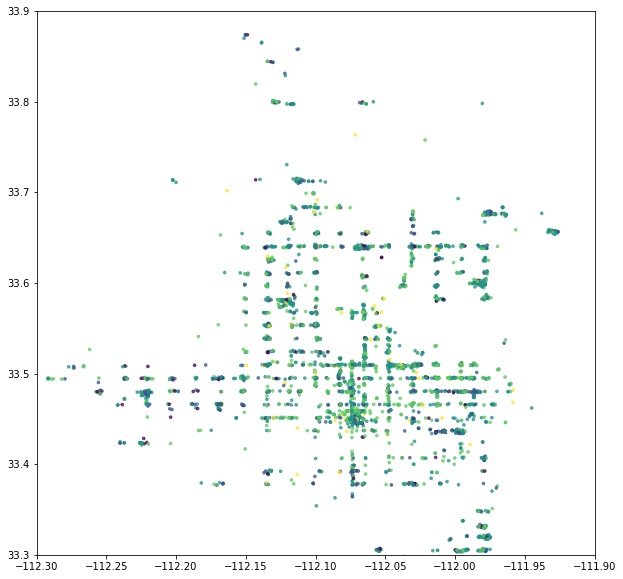

In [20]:
# compare all ratings
col = (featuresdf.stars.astype(int)) * 2
plt.figure(figsize=(10,10))
plt.scatter(x=featuresdf.longitude, y=featuresdf.latitude, c=col, s=7, alpha=0.7)
plt.axis(xmin=-112.3, xmax=-111.9, ymin=33.3, ymax=33.9)
plt.show()

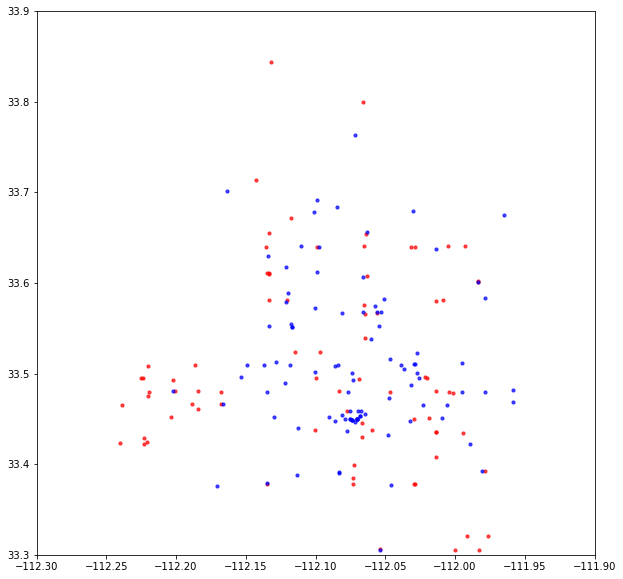

In [21]:
# compare two ratings
plt.figure(figsize=(10,10))
plt.scatter(x=featuresdf[featuresdf.stars==1.5].longitude, y=featuresdf[featuresdf.stars==1.5].latitude, c='r', s=10, alpha=0.7)
plt.scatter(x=featuresdf[featuresdf.stars==5.0].longitude, y=featuresdf[featuresdf.stars==5.0].latitude, c='b', s=10, alpha=0.7)
plt.axis(xmin=-112.3, xmax=-111.9, ymin=33.3, ymax=33.9)
plt.show()

The above charts show us that restaurants follow the gridline structire of the city and there are popular location clusters. A range of ratings is present in clusters and even ratings on the opposite sides of the scale are difficult to distinguish by location alone.

In [22]:
featuresdf1 = featuresdf.drop([u'address', u'attributes.AgesAllowed', u'attributes.ByAppointmentOnly', 
                               u'attributes.AcceptsInsurance', u'attributes.DietaryRestrictions.dairy-free',     
                               u'attributes.DietaryRestrictions.gluten-free', 
                                u'attributes.DietaryRestrictions.halal', 
                                u'attributes.DietaryRestrictions.kosher',
                                u'attributes.DietaryRestrictions.soy-free',      
                                u'attributes.DietaryRestrictions.vegan',          
                                u'attributes.DietaryRestrictions.vegetarian',
                               u'attributes.Open24Hours', u'attributes.RestaurantsCounterService',
                               u'name', u'neighborhood', u'city', u'state', u'stars'], axis=1)
featuresdf1.shape

(3515, 75)

In [23]:
import re
import datetime as dt
from datetime import datetime

In [24]:
# function to convert opening hours to the total number of hours open during each day
def sum_open_hrs(s):
    if type(s) == unicode:
        times = [line[0] for line in re.findall(r'\b(([0-2][0-4]|0?[1-9]):([0-5][0-9]))',s)]
        times = [[i,j] for i,j in zip(times[0::2], times[1::2])]
        fmt = '%H:%M'
        time_objects = [datetime.strptime(b,fmt)-datetime.strptime(a,fmt) for a,b in times]
        finaltime = [td.seconds//3600 for td in time_objects]
        sumtime=sum(finaltime)
        return sumtime
    else:
        return None

In [25]:
featuresdf1[u'hours.Friday'] = featuresdf1[u'hours.Friday'].apply(lambda x: sum_open_hrs(x))
featuresdf1[u'hours.Monday'] = featuresdf1[u'hours.Monday'].apply(lambda x: sum_open_hrs(x))
featuresdf1[u'hours.Saturday'] = featuresdf1[u'hours.Saturday'].apply(lambda x: sum_open_hrs(x))
featuresdf1[u'hours.Sunday'] = featuresdf1[u'hours.Sunday'].apply(lambda x: sum_open_hrs(x))
featuresdf1[u'hours.Tuesday'] = featuresdf1[u'hours.Tuesday'].apply(lambda x: sum_open_hrs(x))
featuresdf1[u'hours.Thursday'] = featuresdf1[u'hours.Thursday'].apply(lambda x: sum_open_hrs(x))
featuresdf1[u'hours.Wednesday'] = featuresdf1[u'hours.Wednesday'].apply(lambda x: sum_open_hrs(x))

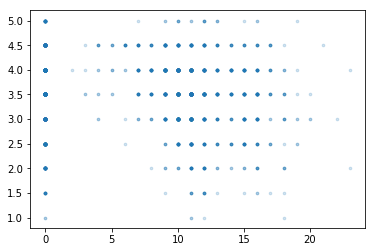

In [26]:
# look at opening hours on a given day
plt.scatter(x=featuresdf1['hours.Sunday'], y=featuresdf.stars, s=7, alpha=0.2)
plt.show()

The chart looks similar for all days: we have missing values (represented as zero) which distort the picture. Where data is available, we can see that a place does not need long opening hours to be rated highly, the trend may even be that good places with high ratings have limited opening hours. 

In [27]:
# convert alcohol categories to numerical
dict_transform = {"none":0, "beer_and_wine":1, "full_bar": 2}
featuresdf1['attributes.Alcohol'] = featuresdf1['attributes.Alcohol'].apply(lambda x: dict_transform.get(x))

In [28]:
# mean ratings per alcohol category:
print 'none:',featuresdf[featuresdf['attributes.Alcohol'] == 'none'].stars.mean()
print 'beer_and_wine:',featuresdf[featuresdf['attributes.Alcohol'] == 'beer_and_wine'].stars.mean()
print 'full_bar:',featuresdf[featuresdf['attributes.Alcohol'] == 'full_bar'].stars.mean()

none: 3.37763078773
beer_and_wine: 3.65288220551
full_bar: 3.52896174863


The availability of alcohol is highly dependent on the type of restaurant (e.g. a sandwich place does not need a full bar). There is little variation in scoring, places with a beer and wine score highest.

In [29]:
# convert noise categories to numerical
noise = set(featuresdf1['attributes.NoiseLevel'])
noise

{nan, u'average', u'loud', u'quiet', u'very_loud'}

In [30]:
noise_transform = {"quiet":1, "average":2, "loud": 3, "very_loud":4}
featuresdf1['attributes.NoiseLevel'] = featuresdf1['attributes.NoiseLevel'].apply(lambda x: noise_transform.get(x))

In [31]:
# mean ratings per noise level category:
print 'quiet:',featuresdf[featuresdf['attributes.NoiseLevel'] == 'quiet'].stars.mean()
print 'average:',featuresdf[featuresdf['attributes.NoiseLevel'] == 'average'].stars.mean()
print 'loud:',featuresdf[featuresdf['attributes.NoiseLevel'] == 'loud'].stars.mean()
print 'very_loud:',featuresdf[featuresdf['attributes.NoiseLevel'] == 'very_loud'].stars.mean()

quiet: 3.52705223881
average: 3.50669412976
loud: 3.09119496855
very_loud: 2.86231884058


There is a trend here for people prefering quieter places.

In [32]:
# convert attire categories to numerical
attire = set(featuresdf1['attributes.RestaurantsAttire'])
attire

{nan, u'casual', u'dressy', u'formal'}

In [33]:
# mean ratings per attire category:
print 'casual:',featuresdf[featuresdf['attributes.RestaurantsAttire'] == 'casual'].stars.mean()
print 'dressy:',featuresdf[featuresdf['attributes.RestaurantsAttire'] == 'dressy'].stars.mean()
print 'formal:',featuresdf[featuresdf['attributes.RestaurantsAttire'] == 'formal'].stars.mean()
print 'formal places ratings:', list(featuresdf[featuresdf['attributes.RestaurantsAttire'] == 'formal'].stars)

casual: 3.42317380353
dressy: 3.73863636364
formal: 3.0
formal places ratings: [4.5, 3.0, 2.5, 2.0]


Dressy scores highest, followed by casual. There are only 4 places classes as 'formal' in the whole data set, only one rated highly.

In [34]:
attire_transform = {"casual":1, "dressy":2, "formal":3}
featuresdf1['attributes.RestaurantsAttire'] = featuresdf1['attributes.RestaurantsAttire'].apply(lambda x: attire_transform.get(x))

In [35]:
# wifi to numerical
wifi = set(featuresdf1['attributes.WiFi'])
wifi

{nan, u'free', u'no', u'paid'}

In [36]:
wifi_transform = {"free":2, "no":0, "paid":1}
featuresdf1['attributes.WiFi'] = featuresdf1['attributes.WiFi'].apply(lambda x: wifi_transform.get(x))

In [37]:
# wifi in relation to scores
print 'free:',featuresdf[featuresdf['attributes.WiFi'] == 'free'].stars.mean()
print 'paid:',featuresdf[featuresdf['attributes.WiFi'] == 'paid'].stars.mean()
print 'no:',featuresdf[featuresdf['attributes.WiFi'] == 'no'].stars.mean()

free: 3.53927911275
paid: 3.23076923077
no: 3.46812080537


Free wiFi does seem to contribute to a higher score on average. However this is a category prone to change and it is hard to imagine a place with paid WiFi today, though it may have been an important feature to reviewers some years back.

In [38]:
# smoking to numerical
sm = set(featuresdf1['attributes.Smoking'])
sm

{nan, u'no', u'outdoor', u'yes'}

In [39]:
sm_transform = {"no":0, "outdoor":1, "yes":2}
featuresdf1['attributes.Smoking'] = featuresdf1['attributes.Smoking'].apply(lambda x: sm_transform.get(x))

In [40]:
# convert object type columns to numeric values
featuresdf2 = featuresdf1.apply(pd.to_numeric, args=('coerce',))

In [41]:
# drop columns that are not used
business_id = featuresdf1[u'business_id'].reset_index(drop=True)
featuresdf3 = featuresdf2.drop([u'business_id', u'attributes.BYOB', u'attributes.BYOBCorkage', u'attributes.Corkage', u'categories', u'postal_code'], axis=1)
featuresdf3 = featuresdf3.reset_index(drop=True)
featuresdf3.head()

,attributes.Alcohol,attributes.Ambience.casual,attributes.Ambience.classy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.intimate,attributes.Ambience.romantic,attributes.Ambience.touristy,attributes.Ambience.trendy,attributes.Ambience.upscale,...,hours.Monday,hours.Saturday,hours.Sunday,hours.Thursday,hours.Tuesday,hours.Wednesday,is_open,latitude,longitude,review_count
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,33.505928,-112.038847,10
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,12.0,12.0,12.0,12.0,12.0,1,33.478043,-111.986370,63
2,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,11.0,11.0,11.0,11.0,11.0,1,33.445363,-112.067496,127
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,12.0,12.0,11.0,11.0,11.0,1,33.465952,-112.121577,13
4,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,11.0,11.0,11.0,11.0,11.0,1,33.599661,-111.982293,232


__Preparing the X-matrix and y-vector__

In [42]:
import numpy.ma as ma

In [43]:
# extract values into numpy array
f3val = featuresdf3.values
# replace nan values with column-wise means
f3val = np.where(np.isnan(f3val), ma.array(f3val, mask=np.isnan(f3val)).mean(axis=0), f3val) 
np.isnan(np.sum(f3val))

False

In [44]:
f3val.shape

(3515L, 69L)

In [45]:
y_feat = phoenix[u'stars'].values
y_feat.shape

(3515L,)

Now split data into training and test sets and try different algorithms:

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
Xf_train, Xf_test, yf_train, yf_test, indices_train, indices_test = train_test_split(f3val, y_feat, featuresdf3.index, test_size=0.3, random_state=8)

In [48]:
print Xf_train.shape, yf_train.shape

(2460L, 69L) (2460L,)


In [49]:
indices_train

Int64Index([  92, 2981,  879, 1199, 1260,   99,  322, 1569, 1870, 1997,
            ...
            2096, 1384, 2899, 2184,  986, 2181, 2409, 2033, 1364,  451],
           dtype='int64', length=2460)

__Linear Regression Model__

In [50]:
from sklearn import linear_model

In [51]:
from sklearn.metrics import mean_squared_error

In [52]:
reg = linear_model.LinearRegression()
reg.fit(Xf_train, yf_train)
print reg.score(Xf_train, yf_train)
print reg.score(Xf_test, yf_test)
print mean_squared_error(yf_test, reg.predict(Xf_test))

0.217502609955
0.180946151502
0.581617457994


__Ridge Regression__

In [53]:
from sklearn.linear_model import Ridge

In [54]:
ridge_reg = Ridge(alpha=0.001)
ridge_reg.fit(Xf_train, yf_train)
print ridge_reg.score(Xf_train, yf_train)
print ridge_reg.score(Xf_test, yf_test)
print mean_squared_error(yf_test, ridge_reg.predict(Xf_test))

0.217502609689
0.180945294494
0.581618066563


In [55]:
import matplotlib.pyplot as plt

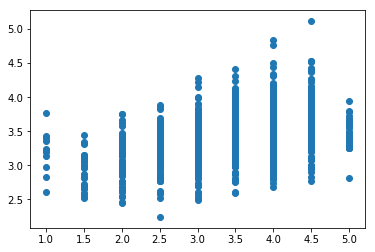

In [56]:
## visualize results
plt.scatter(x=yf_test, y=ridge_reg.predict(Xf_test))
plt.show()

Both models give the same results. Due to the presence of categorical and binary features, the data cannot be presented well by a linear model and we will only use this result as a benchmark to verify which alternative models can provide a substantially better score. We will test the Random Forest based ensemble methods and the MLP neural network model.

__Random Forest Regression Model__

In [57]:
from sklearn.ensemble import RandomForestRegressor

In [58]:
rf_regr = RandomForestRegressor(max_depth=100, random_state=0)
rf_regr.fit(Xf_train, yf_train)
print rf_regr.score(Xf_train, yf_train)
print rf_regr.score(Xf_test, yf_test)
print mean_squared_error(yf_test, rf_regr.predict(Xf_test))

0.860252946219
0.2441150431
0.536760663507


__Gradient Boosting Regression Model__

In [59]:
from sklearn.ensemble import GradientBoostingRegressor

In [60]:
gbr = GradientBoostingRegressor(n_estimators=200, loss= 'ls',  max_depth=5, learning_rate=0.1, max_features='log2')
gbr.fit(Xf_train, yf_train)
print gbr.score(Xf_train, yf_train)
print gbr.score(Xf_test, yf_test)
print mean_squared_error(yf_test, gbr.predict(Xf_test))

0.703459105291
0.298088978455
0.498433289628


This is a tangible improvement of results and we can use the scatter plot and histigram of errors to visualize results:

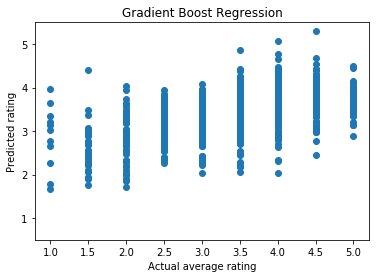

In [61]:
plt.scatter(x=yf_test, y=gbr.predict(Xf_test))
plt.title('Gradient Boost Regression')
plt.xlabel('Actual average rating')
plt.ylabel('Predicted rating')
plt.axis(ymin=0.5, ymax=5.5)
plt.show()

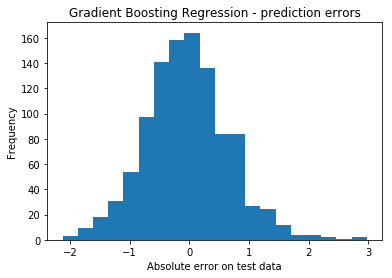

In [62]:
plt.hist(gbr.predict(Xf_test) - yf_test, bins=20)
plt.title('Gradient Boosting Regression - prediction errors')
plt.xlabel('Absolute error on test data')
plt.ylabel('Frequency')
plt.show()

In [63]:
print 'Mean of the absolute predction error: ', (yf_test - yf_test.mean()).mean()
print 'Standard deviation of the mean-centered raw data: ', (yf_test - yf_test.mean()).std()
print 'Standard deviation of the absolute prediction error: ', (gbr.predict(Xf_test) - yf_test).std()

Mean of the absolute predction error:  -1.34700044694e-17
Standard deviation of the mean-centered raw data:  0.842679617266
Standard deviation of the absolute prediction error:  0.705039292108


The reduced standard deviation of the predicted data vs. raw data means that the algorithm did produce some predictive power; however the prediction is not very accurate or robust.

__MLP Regression Model__

In [64]:
from sklearn.neural_network import MLPRegressor

In [65]:
mlpr = MLPRegressor(solver='lbfgs', alpha=0.0001, hidden_layer_sizes = (1000,), learning_rate='adaptive')
mlpr.fit(Xf_train, yf_train)
print mlpr.score(Xf_train, yf_train)
print mlpr.score(Xf_test, yf_test)
print mean_squared_error(yf_test, mlpr.predict(Xf_test))

0.254314803583
0.199206632581
0.568650527179


__Summarize results in data frame__

In [66]:
feature_results = pd.DataFrame(zip(business_id[indices_test], yf_test, gbr.predict(Xf_test)))
feature_results.columns = ['business_id', 'yelp_rounded_rating', 'GBR_feature_prediction']
feature_results.head()

,business_id,yelp_rounded_rating,GBR_feature_prediction
0,TEqsEqIRFSQdDm8jwPHdkw,3.5,3.188703
1,MO8vR9uw--ELG5J8CbdZCA,5.0,3.206683
2,bBM6OguT_lLYSlq4NaMuzw,3.5,3.015560
3,5WtKBzHv1mL2-w1wcz3kpw,3.0,3.563569
4,bbMJNMWjd7n2ztcE79ZwfQ,1.5,4.415314


In [67]:
feature_results.shape

(1055, 3)

The neural network model performs worse than gradient boosting regression and does not offer an improvement over the linear model.

__Conclusion__

The best prediction result was obtained using Gradient Boosting regression on the full set of features. This gave an R^2 value of 0.68 on the training data and 0.34 on the test data, with a test MSE of 0.45. From these results and the scatter plot, we can conclude that there is a significant amount of randomness in the data and that a given restaurant's features can be used to provide a broad estimate of its probable average ratings, but not a very accurate prediction. In business terms, the 'specification' of a restaurant lacks the subjective information that is important ti users when rating a restaurant - items such as quality of food, level of service, and overall feeling of well-being. This is the information we will try to capture from the text of the reviews in order to determine the reviewer's sentiment and likely rating score.

# 3. Importing Reviews Data

In [68]:
# extract reviews data from the json file and store to data frame
review_json_filepath = os.path.abspath('data/dataset/review.json')

biz_data = []
rating_data = []
review_data = []


with codecs.open(review_json_filepath, encoding='utf_8') as f:
    for line in f:
        business = json.loads(line)
        bus_id = business[u'business_id'] 
        # filter restaurants in Phoenix
        if bus_id not in phx_ids:
            continue
        biz_data.append(bus_id)
        rating_data.append(business[u'stars'])
        review_data.append(business[u'text'])

print len(biz_data)
print len(rating_data)
print len(review_data)

302403
302403
302403


In [69]:
reviews_df = pd.DataFrame(zip(biz_data, rating_data, review_data))
reviews_df.columns = ['business_id', 'stars_rating', 'review']
reviews_df.head(10)

,business_id,stars_rating,review
0,_mqUzNXs_sJ1EJYgYZYszg,4,A really good sandwich place. It's location is...
1,_mqUzNXs_sJ1EJYgYZYszg,5,The food was definitely solid but what stood o...
2,_mqUzNXs_sJ1EJYgYZYszg,4,Great place to grab lunch. The location is a l...
3,_mqUzNXs_sJ1EJYgYZYszg,5,"What a find, right behind the Radisson, fresh ..."
4,_mqUzNXs_sJ1EJYgYZYszg,5,I work in a office building right around the c...
5,_mqUzNXs_sJ1EJYgYZYszg,3,I can't figure out why their food isn't that g...
6,_mqUzNXs_sJ1EJYgYZYszg,4,"Only open for lunch spot, a nice little sandwi..."
7,_mqUzNXs_sJ1EJYgYZYszg,5,After arriving at PHX airport we searched for ...
8,_mqUzNXs_sJ1EJYgYZYszg,3,I have visited The Lunch Lounge 3 times since ...
9,_mqUzNXs_sJ1EJYgYZYszg,5,"Happy to have found this place! Great food, de..."


Reviews data stored in 'reviews_df' data frame and includes business id, stars rating and revew text. Line below extracts one sample review text (stored as unicode):

In [70]:
reviews_df.review[299522]

u'I absolutely always enjoy the jade red chicken.  A little disappointed they do not have egg rolls but the heat selection of Asian beers definitely make up for it'

In [71]:
# mean of the ratings
reviews_df.stars_rating.mean()

3.803288988535167

In [72]:
reviews_df.stars_rating.value_counts().sort_index()

1     31578
2     27113
3     36658
4     80922
5    126132
Name: stars_rating, dtype: int64

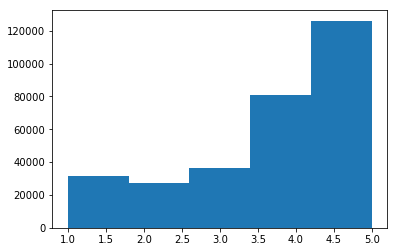

In [73]:
# histogram of individual ratings
plt.hist(reviews_df.stars_rating, bins=5)
plt.show()

# 4. Sentiment Modeling

## 4.1. Importing the Trained NLP Model

We now have two data frames for the set of approx. 3500 restaurant businesses in Phoenix. - one with business information and one containing 300,000+ reviews about them. 

The next step uses the NLP model (already trained on the entire dataset of 2.9 million reviews) to extract summary information from the reviews about each business and add this information to the features matrix.

The model will be imported as a gensim word2vec model and each review will be converted to a feature vector. As reviews vary in length, a method is needed to obtain a representative feature vector for each review in the same format. The solution used here is to generate a feature vector for each word in the review (in its lemma form, excluding punctuation, white space and stop words), add vectors for all words in the review, and divide by the number of words. This will create an average feature vector that is a representation of the broad meaning of the review.

In [74]:
# this is to access the file where the ENglish language model is located
import sys
sys.path.append('C:\Windows\System32\.env\Lib\site-packages')

In [75]:
# import spact for processing text in reviews
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load() 

In [76]:
# import gensime module to use word2vec model created
from gensim.models import Word2Vec

C:\Users\Work\Anaconda2\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using CNTK backend
C:\Users\Work\Anaconda2\lib\site-packages\keras\backend\cntk_backend.py:19: UserWarning: CNTK backend warning: GPU is not detected. CNTK's CPU version is not fully optimized,please run with GPU to get better performance.
  'CNTK backend warning: GPU is not detected. '


In [77]:
# import the trained word2vec model
model = Word2Vec.load('data/intermediate/word2vec_model_all')

In [78]:
# create set of words in word2vec model
index2word_set = set(model.wv.index2word)

In [79]:
# show feature vector for selected words
model['excellent']

array([ 0.44177014,  0.34545311, -0.4863095 ,  0.35393116,  0.20394039,
        0.32689789, -0.04189698,  0.09583075,  0.59013194,  0.13289815,
       -0.43105602,  0.4870742 , -0.16222502, -0.2792412 ,  0.29100522,
       -0.23376985, -0.16161127, -0.33476841,  0.11884616, -0.02219654,
       -0.06832016,  0.18777724, -0.31993359,  0.41420466,  0.02011142,
        0.34190252, -0.02196711,  0.16111246, -0.16246185,  0.0499949 ,
       -0.19975521, -0.16161473,  0.17163743, -0.22013833,  0.23611847,
       -0.27877772, -0.37166238,  0.0329407 ,  0.58188915,  0.24307698,
        0.4378143 ,  0.02364679, -0.20428382,  0.06199164,  0.05651153,
       -0.15151869,  0.58012015, -0.288416  ,  0.45948359,  0.33597344,
        0.13952601, -0.23661782, -0.20378302,  0.42699447, -0.07695791,
       -0.21763811, -0.12416524,  0.39530164,  0.24426317, -0.08625464,
        0.01122354,  0.07476675,  0.07364706,  0.05514677,  0.03141041,
       -0.44871995, -0.64922386,  0.27328208, -0.46428677, -0.07

In [80]:
def punct_space_stop(token):
    """
    helper function to eliminate tokens
    that are pure punctuation, whitespace and stop words
    """
    
    return token.is_punct or token.is_space or token.is_stop


In [81]:
def makeFeatureVec(words, model, num_features):
    """
    Function to average all of the word vectors in a review
    """
    # process the unicode input text to tokens
    nlp_words = nlp(words)
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in nlp_words:
        if not punct_space_stop(word):
            # convert to lemma and unicode 
            uw = unicode(word.lemma_)
            if uw in index2word_set: 
                nwords = nwords + 1.
                featureVec = np.add(featureVec,model[uw])
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec

In [82]:
def getAvgFeatureVecs(reviews, model, num_features):
    """
    Function to calculate the average feature vector for each 
    review given a list of reviews and return a 2D numpy array. 
    If list of reviews is a pandas DataFrame column, a slice of the column 
    needs to be fed into the function and not simply the column name
    """
    # Initialize a counter
    counter = 0
    # 
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    # 
    # Loop through the reviews and update progress everu 1000 reviews
    for review in reviews:
        # keep track of progress
        if counter%10000 == 0:
            print "Review %d of %d" % (counter, len(reviews)) 
            
        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
       
        # Increment the counter
        counter = counter + 1
    return reviewFeatureVecs


## 4.2. Random Forest Classifier 

The first attemt to classify data will use a random forest model. Paramneters to be tuned to optimize the model are: number of trees used, maximum tree depth, minimum items in a leaf. In addition the n_jobs parameter can be set to parallelize the process, using all 4 cores (importnat for the whole data set of 300k+ reviews).

In [83]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
# function to map star ratings to sentiment
# 1-2 stars: set to 0, 'negative review'
# 4-5 stars: set to 1, 'positive review'
# 3 stars: net to None and drop values at later stage, 'neutral review that is not useful for sentiment analysis'
def ratings_map(x):
    if x in [1,2]:
        xnew = 0
    elif x in [4,5]:
        xnew = 1
    else: 
        xnew = None
    return xnew

In [85]:
# add sentiment column to the entire data set (300k reviews)
reviews_df.loc[:,'sentiment'] = reviews_df.stars_rating.apply(lambda x: ratings_map(x))
reviews_df.shape

(302403, 4)

In [86]:
# drop the 3's and save to reviews_df1
reviews_df1 = reviews_df.dropna()
reviews_df1.shape

(265745, 4)

In [87]:
%%time
# create feature matrix X and results vector y
# for X need to extract feature vectors for all reviews in the large data set

if 0==1:
    X2 = getAvgFeatureVecs(reviews_df1.review[:], model, 100)
    # if the array contains NaN, convert to zero
    X21 = np.nan_to_num(X2) 
    np.save('X_matrix', X21)
    
else: 
    X21 = np.load('X_matrix.npy')
y2 = reviews_df1.sentiment

Wall time: 269 ms


In [88]:
# split data into training and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X21, y2, test_size=0.3)

In [89]:
%%time
# fit random forest model to training set
# use to predict sentiment on test set
# evaluate score as proportion of accurate predictions

forest2 = RandomForestClassifier(n_estimators = 500, n_jobs=4)
forest2 = forest2.fit(X2_train, y2_train)
result2 = forest2.predict(X2_test)
score = (result2 - y2_test) == 0
print float(score.sum())/len(score)

0.914643018414
Wall time: 13min 17s


In [90]:
y2_pred = forest2.predict(X2_test)

In [91]:
from sklearn.metrics import precision_score, recall_score

In [92]:
# precision and recall on positive sentiment reviews
print 'Precision score: ', precision_score(y2_pred, y2_test)
print 'Recall score: ', recall_score(y2_pred, y2_test)

Precision score:  0.975135587492
Recall score:  0.920123914232


In [93]:
# precision and recall on negative sentiment reviews
print 'Precision score (negative sentiment): ', precision_score(y2_pred, y2_test, pos_label=0)
print 'Recall score (negative sentiment): ', recall_score(y2_pred, y2_test, pos_label=0)

Precision score (negative sentiment):  0.700915448911
Recall score (negative sentiment):  0.888624567474


In [94]:
# proportion of positive reviews
positive_sentiment = (y2_test ==1).sum() / float(len(y2_test))
positive_sentiment

0.77940143495057945

__Results:__

The RandomForestClassifier(n_estimators = 500, n_jobs=4) gives a score of 0.916. The best result was obtained using default paramteres; changing settings did not result in any improvement. As the positive reviews represent 78% of the data, the negative reviews are harder to identify and the critical score is the precision on negative reviews, at 0.70.

## 4.3. Neural Network Classifier 

The next part is an attempt to produce better prediction results using a neural network model on the same data. The model used is the Multi-layer Perceptron (MLP) classifier from the scikit-learn library. Further, a range of parameters will be tested in order to tune the model for optimal results.

In [95]:
from sklearn.neural_network import MLPClassifier

In [96]:
clf = MLPClassifier(solver='adam', alpha=1e-4, random_state=1)

In [97]:
clf.fit(X2_train, y2_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [98]:
clf_result = clf.predict(X2_test)
score = (clf_result - y2_test) == 0
print float(score.sum())/len(score)

0.940544879835


In [99]:
# precision and recall on positive sentiment reviews
print 'Precision score: ', precision_score(clf_result, y2_test)
print 'Recall score: ', recall_score(clf_result, y2_test)

Precision score:  0.961150361298
Recall score:  0.962513497397


In [100]:
# precision and recall on negative sentiment reviews
print 'Precision score (negative sentiment): ', precision_score(clf_result, y2_test, pos_label=0)
print 'Recall score (negative sentiment): ', recall_score(clf_result, y2_test, pos_label=0)

Precision score (negative sentiment):  0.867743219423
Recall score (negative sentiment):  0.86342291372


Results:
 - MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=1); score: 0.9400
 - MLPClassifier(solver='lbfgs', alpha=1e-4, random_state=1); score: 0.9406
 - MLPClassifier(solver='lbfgs', alpha=1e-3, random_state=1); score: 0.9397
 - MLPClassifier(solver='sgd', alpha=1e-4, random_state=1); score: 0.9360
 - MLPClassifier(solver='sgd', alpha=1e-4, random_state=1, learning_rate='adaptive'); score: 0.9362
 - MLPClassifier(solver='sgd', alpha=1e-4, random_state=1, learning_rate='invscaling'); score: 0.7796
 - MLPClassifier(solver='adam', alpha=1e-4, random_state=1); score: 0.9412 
 - MLPClassifier(solver='adam', alpha=1e-3, random_state=1); score = 0.9419 (this took much longer to run)

The standard MLP classifier, with default settings gives a prediction accuracy of 94.0%. Using different solvers and varying values of alpha (L2 regularization parameter that helps avoid overfitting) gave little variation in accuracy. The best result obtained was 94.2% using the 'adam' solver. According to the scikit-learn documentation, the 'adam' solver works relatively well on large data sets. The only outlier in the model is the 'sgd' solver with an inverse scaling learning rate, which only gave 78% accuracy.  

Overall, this model gave better results that the random forest model. The critical parameter, precision on negative reviews, gave a score of 0.87 using the MLP classifier compared to 0.70 using the Random Forest classifier.

# 5. Predicting Star Ratings

The previous section analyzed sentiment predictions for reviews as a positive (rating of 4 or 5 stars) or negative (rating of 1 or 2 stars). The 3-star reviews were ignored altogether. Using a random forest or MLP classifier bith gave good results with accuracy of 92% (random forest) and 94% (MLP). This is not surprising, as the elimination of 3-star reviews has provided a clearer separation of the two classes.

In the next section, we will try to predict the actual star rating of a review. In order to provide a more computationally manageable data set, the analysis will be performed on a slice of the original data, containing 56,590 reviews. This will be split into training and test data. The trining set will be used to 'learn' the data, and a test sample will be used to predict the data and obtain a prediction accuracy as the mean squared error (MSE). 

We will first use classification models, taking the 1-5 star ratings as class labels. The classifiers used are:
- Random Forest
- Ada Boost
- MLP

The scoring parameters will measure the proportion of correct predictions for each model, and the proportion of 'bad' predictions (where the error is 2 or higher) and the MSE.

Next, regression models will be used to predict the star ratings as a quantitative measure. The MLP and Gradient Boosting regression models will be used.

__Separate training and test data from the features analysis in order to compare predictive power of features and reviews on the same test data:__

First, we will make sure only to include training samples from the previous features analysis. The test data from the features analysis will also form the test data for review predictions, therefore we will be comparing two models on the same test data.

In [101]:
training_set = set(business_id[indices_train])
test_set = set(business_id[indices_test])
print len(training_set), len(test_set)

2460 1055


In [102]:
reviews_df['train'] = reviews_df['business_id'].apply(lambda x: x in training_set)
reviews_sample = reviews_df[reviews_df['train'] == True]
reviews_sample = reviews_sample.loc[:80000,:]
reviews_sample.shape

(56590, 5)

In [103]:
%%time
if 0 == 1:
    X3 = getAvgFeatureVecs(reviews_sample.review[:], model, 100)
    np.save('X_matrix_classification', X3)
else: X3 = np.load('X_matrix_classification.npy')

Wall time: 60 ms


In [104]:
# this is to resolve the warning raised and convert nan vaslues to zeros 
# only a handful of such cases are present in the data set and will not harm the results
X3 = np.nan_to_num(X3)

In [105]:
y3 = reviews_sample.stars_rating.values
np.unique(y3, return_counts=True)

(array([1, 2, 3, 4, 5], dtype=int64),
 array([ 7208,  5587,  7329, 15123, 21343], dtype=int64))

In [106]:
# split data into training and test sets
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3)

## 5.1 Classification Models 

__Random Forest Classifier__

In [107]:
# random forest classifier

rfc = RandomForestClassifier(n_estimators = 200, max_depth = 100, min_samples_leaf = 1, n_jobs=4)
rfc = rfc.fit(X3_train, y3_train)
result_rfc = rfc.predict(X3_test)
mse_rfc = mean_squared_error(y3_test, result_rfc)
correct_pred_rfc = (result_rfc - y3_test) == 0
print 'MSE on random forect classifier: ', mse_rfc
print 'Proportion of correct predictions: ', correct_pred_rfc.sum() / float(len(y3_test))

MSE on random forect classifier:  1.27278082111
Proportion of correct predictions:  0.536372739589


__Ada Boost Classifier__

In [108]:
from sklearn.ensemble import AdaBoostClassifier

In [109]:
ada = AdaBoostClassifier(n_estimators = 100, random_state=1)
ada = ada.fit(X3_train, y3_train)
result_ada = ada.predict(X3_test)
mse_ada = mean_squared_error(y3_test, result_ada)
correct_pred_ada = (result_ada - y3_test) == 0
print 'MSE on Ada Boost classifier: ', mse_ada
print 'Proportion of correct predictions: ', correct_pred_ada.sum() / float(len(y3_test))              

MSE on Ada Boost classifier:  1.12805560464
Proportion of correct predictions:  0.534252223597


__MLP Classifier__

In [110]:
# MLPClassifier

mlpc = MLPClassifier(solver='adam', alpha=1e-4, random_state=1)
mlpc = mlpc.fit(X3_train, y3_train)
result_mlpc = mlpc.predict(X3_test)
mse_mlpc = mean_squared_error(y3_test, result_mlpc)
correct_pred_mlpc = (result_mlpc - y3_test) == 0
print 'MSE on MLP classifier: ', mse_mlpc
print 'Proportion of correct predictions: ', correct_pred_mlpc.sum() / float(len(y3_test))

MSE on MLP classifier:  0.85026800966
Proportion of correct predictions:  0.572421511457


__Summary of Results__

In [111]:
# proportion of 'bad' predictions
bads_rfc = ((result_rfc - y3_test) >= 2).sum() / float(len(y3_test))
bads_ada = ((result_ada - y3_test) >= 2).sum() / float(len(y3_test))
bads_mlpc = ((result_mlpc - y3_test) >= 2).sum() / float(len(y3_test))

print 'Random forest classifier bad predictions: ', bads_rfc
print 'Ada Boost classifier bad predictions: ', bads_ada
print 'MLP classifier bad predictions: ', bads_mlpc


Random forest classifier bad predictions:  0.101372445073
Ada Boost classifier bad predictions:  0.0702715438534
MLP classifier bad predictions:  0.0441774165047


In [112]:
# accurate predictions
acc_rfc = correct_pred_rfc.sum() / float(len(y3_test))
acc_ada = correct_pred_ada.sum() / float(len(y3_test))
acc_mlpc = correct_pred_mlpc.sum() / float(len(y3_test))

In [113]:
results_summary = pd.DataFrame({'MSE': [mse_rfc, mse_ada, mse_mlpc],
                               'Accurate predictions': [acc_rfc, acc_ada, acc_mlpc],
                               'Bad predictions': [bads_rfc, bads_ada, bads_mlpc]})
results_summary.index = ['Random Forest', 'Ada Boost', 'MLP'] 
results_summary                               

,Accurate predictions,Bad predictions,MSE
Random Forest,0.536373,0.101372,1.272781
Ada Boost,0.534252,0.070272,1.128056
MLP,0.572422,0.044177,0.850268


For this clasification exercise, the MLP classifier gave the best results, with the lowest MSE, highest proportion of accurate predictions and lowest number of 'bad' predictions with an error >= 2. The Ada Boost and random forest models were equal in accurate predictions, but Ada Boost outperformed the random forest model by having fewer 'bad' predictions, resulting in a lower mean squared error. 

A possible further improvement of the neural network classifier would be to use a deep learning model, e.g. using the keras package.

A simpler way is to first try regression models on the same data and compare results:

## 5.2 Regression Models 

__MLP Regression__

In [114]:
%%time
mlpr1 = MLPRegressor(solver='lbfgs', alpha=0.0001, hidden_layer_sizes = (1000,), learning_rate='adaptive')
mlpr1.fit(X3_train, y3_train)
y3_pred = mlpr1.predict(X3_test)

Wall time: 6min 11s


In [115]:
print 'Training score: ', mlpr1.score(X3_train, y3_train)
print 'Test score: ', mlpr1.score(X3_test, y3_test)
print 'MSE: ', mean_squared_error(y3_test, y3_pred)
# convert predictions to integer values to make the MSE comparable to classifier models
print 'MSE on integer-rounded predictions: ', mean_squared_error(y3_test, np.rint(y3_pred))

Training score:  0.691988059175
Test score:  0.678802040696
MSE:  0.626020411502
MSE on integer-rounded predictions:  0.716322082818


__Gradient Boosting__

In [116]:
%%time
# try a Gradient Boosting Regresion model to compare results:
gbr1 = GradientBoostingRegressor(n_estimators=200, loss= 'ls',  max_depth=5, learning_rate=0.1, max_features='log2')
gbr1.fit(X3_train, y3_train)
y3_pred_gb = gbr1.predict(X3_test)

Wall time: 28.6 s


In [117]:
print 'Training score: ',gbr1.score(X3_train, y3_train)
print 'Test score: ',gbr1.score(X3_test, y3_test)
print 'MSE: ',mean_squared_error(y3_test, y3_pred_gb)
# convert predictions to integer values to make the MSE comparable to classifier models
print 'MSE on integer-rounded predictions: ',mean_squared_error(y3_test, np.rint(y3_pred_gb))

Training score:  0.712388365472
Test score:  0.623898534365
MSE:  0.733028300657
MSE on integer-rounded predictions:  0.825823172528


__Now construct the X-matrix and y-vector for test reviews:__

In [118]:
test_reviews = reviews_df[reviews_df['train'] == False]
test_reviews.head()

,business_id,stars_rating,review,sentiment,train
0,_mqUzNXs_sJ1EJYgYZYszg,4,A really good sandwich place. It's location is...,1.0,False
1,_mqUzNXs_sJ1EJYgYZYszg,5,The food was definitely solid but what stood o...,1.0,False
2,_mqUzNXs_sJ1EJYgYZYszg,4,Great place to grab lunch. The location is a l...,1.0,False
3,_mqUzNXs_sJ1EJYgYZYszg,5,"What a find, right behind the Radisson, fresh ...",1.0,False
4,_mqUzNXs_sJ1EJYgYZYszg,5,I work in a office building right around the c...,1.0,False


In [119]:
if 0 == 1:
    X_test_reviews = getAvgFeatureVecs(test_reviews.review[:], model, 100)
    np.save('X_test_reviews', X_test_reviews)
else:
    X_test_reviews = np.load('X_test_reviews.npy')

In [120]:
X_test_reviews = np.nan_to_num(X_test_reviews)

In [121]:
test_reviews.loc[:,'MLPC_predicted_rating'] = mlpc.predict(X_test_reviews)
test_reviews.loc[:,'MLPR_predicted_rating'] = mlpr1.predict(X_test_reviews)
test_reviews.tail()

C:\Users\Work\Anaconda2\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Work\Anaconda2\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,business_id,stars_rating,review,sentiment,train,MLPC_predicted_rating,MLPR_predicted_rating
302169,rCD-XFLBhscylZdg1OkCSQ,5,"The food is good,there is no question about it...",1.0,False,5,3.859756
302170,rCD-XFLBhscylZdg1OkCSQ,3,"Salvadoreno # 2 is a very plain, very simple r...",NaN,False,4,3.174072
302171,rCD-XFLBhscylZdg1OkCSQ,2,"I Love this place, I usually order Pupusas but...",0.0,False,1,1.985514
302172,rCD-XFLBhscylZdg1OkCSQ,5,This place was a gem. I looked when I first mo...,1.0,False,5,4.614179
302173,rCD-XFLBhscylZdg1OkCSQ,4,This place is great. The papusas are fantastic...,1.0,False,4,4.104722


In [122]:
predicted_test_reviews = mlpc.predict(X_test_reviews)
predicted_test_reviews.shape

(86349L,)

In [123]:
print 'MSE on MLPC: ', mean_squared_error(test_reviews.MLPC_predicted_rating, test_reviews.stars_rating)
print 'MSE on MLPR: ', mean_squared_error(test_reviews.MLPR_predicted_rating, test_reviews.stars_rating)
print 'MSE on MLPR rounded to integer ratings: ', mean_squared_error(np.rint(test_reviews.MLPR_predicted_rating), test_reviews.stars_rating)

MSE on MLPC:  0.788625230171
MSE on MLPR:  0.583634379766
MSE on MLPR rounded to integer ratings:  0.668785973202


The regression model provides better predictions on the reviews, with a significantly smaller MSE (0.58 for teh regression model vs. 0.80 for classification). Rounding the regression result to integer star ratings provides a level comparison between the two models and the regression model still provides a better result with MSE of 0.67. 
The regression model is the more natural choice here due to the quantitative meaning of the ratings that provide a scale for the regression to fit to. However the scaling from 1 to 5 is an arbitrary scale given by Yelp and does not necessarily mean that, for example, a rating of 5 is 5 times 'better' than a rating of 1 and 2.5 times 'better' than a rating of 2. Testing transformations of the scale may result in improvements of the prediction performance.

__Now group reviews by business_id and average rating predictions:__

In [124]:
grouped_by_business = test_reviews.groupby('business_id')['stars_rating', 'MLPC_predicted_rating', 'MLPR_predicted_rating'].mean()
grouped_by_business.columns = ['yelp_avg_rating', 'MLPC_predicted_avg_rating', 'MLPR_predicted_avg_rating']
grouped_by_business.head(5)

,yelp_avg_rating,MLPC_predicted_avg_rating,MLPR_predicted_avg_rating
business_id,,,
--g-a85VwrdZJNf0R95GcQ,4.458333,4.458333,4.470844
-0WegMt6Cy966qlDKhu6jA,2.162162,2.405405,2.547603
-0aIra_B6iALlfqAriBSYA,4.863636,4.636364,4.389172
-2isRNVb6PDuBagELL5EBw,2.875000,2.750000,2.812636
-8JaNeG3etLgOVyg2gOIiA,3.770492,4.000000,3.903735


In [125]:
grouped_by_business.shape

(1055, 3)

In [126]:
print 'Grouped MSE on MLPC: ', mean_squared_error(grouped_by_business.yelp_avg_rating, grouped_by_business.MLPC_predicted_avg_rating)
print 'Grouped MSE on MLPR: ', mean_squared_error(grouped_by_business.yelp_avg_rating, grouped_by_business.MLPR_predicted_avg_rating)

Grouped MSE on MLPC:  0.115391693967
Grouped MSE on MLPR:  0.0959101808233


The averaging of reviews by business has narrowed the margin between the classification and regression models and they now both provide a very robust prediction, with MSE of approx. 0.1.

__Merge feature predictions with reviews predictions and compare results:__

In [127]:
grouped_by_business = grouped_by_business.reset_index(drop=False)
overall_results = grouped_by_business.merge(feature_results, on='business_id')
overall_results.head(10)

,business_id,yelp_avg_rating,MLPC_predicted_avg_rating,MLPR_predicted_avg_rating,yelp_rounded_rating,GBR_feature_prediction
0,--g-a85VwrdZJNf0R95GcQ,4.458333,4.458333,4.470844,4.5,3.597609
1,-0WegMt6Cy966qlDKhu6jA,2.162162,2.405405,2.547603,2.0,3.187335
2,-0aIra_B6iALlfqAriBSYA,4.863636,4.636364,4.389172,5.0,3.688692
3,-2isRNVb6PDuBagELL5EBw,2.875000,2.750000,2.812636,3.0,2.803295
4,-8JaNeG3etLgOVyg2gOIiA,3.770492,4.000000,3.903735,4.0,3.973172
5,-9eNGMp8XiygI8t8QFuFWw,3.704918,3.795082,3.779318,3.5,3.976834
6,-A9sm-E6uQxWTJ_MuyOzFw,3.180952,3.438095,3.386005,3.0,3.433350
7,-DrDzpZaMrNnH55ZVyTXRQ,3.516129,3.806452,3.819508,3.5,3.616377
8,-Du1WSRseqUXbCt_K-D-ww,3.481481,3.444444,3.265264,3.5,3.512135
9,-FveSBaantlFExq__ESLcw,3.750000,3.500000,3.823602,4.0,3.621034


In [128]:
methods = ['MLPC_predicted_avg_rating', 'MLPR_predicted_avg_rating', 'GBR_feature_prediction']
for method in methods:
    errors = overall_results[method] - overall_results.yelp_avg_rating
    print method, ':\t', errors.mean(), '\t', errors.std()

MLPC_predicted_avg_rating :	0.0328016569627 	0.338266469265
MLPR_predicted_avg_rating :	0.0206445153755 	0.309151381728
GBR_feature_prediction :	-0.0301212137719 	0.685894095661


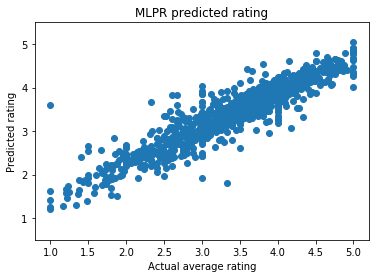

In [129]:
# scatter plot of the MLPR model
plt.scatter(x=overall_results.yelp_avg_rating, y=overall_results.MLPR_predicted_avg_rating)
plt.title('MLPR predicted rating')
plt.xlabel('Actual average rating')
plt.ylabel('Predicted rating')
plt.axis(ymin=0.5, ymax=5.5)
plt.show()

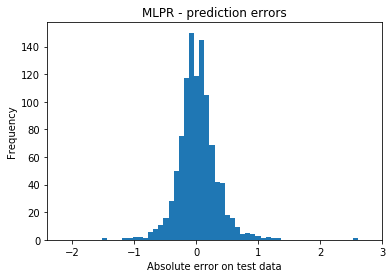

In [130]:
plt.hist(overall_results.MLPR_predicted_avg_rating - overall_results.yelp_avg_rating, bins=50)
plt.title('MLPR - prediction errors')
plt.xlabel('Absolute error on test data')
plt.ylabel('Frequency')
plt.axis(xmin=-2.4, xmax=3.0)
plt.show()

In [131]:
overall_results.corr()

,yelp_avg_rating,MLPC_predicted_avg_rating,MLPR_predicted_avg_rating,yelp_rounded_rating,GBR_feature_prediction
yelp_avg_rating,1.000000,0.913491,0.930256,0.985207,0.558144
MLPC_predicted_avg_rating,0.913491,1.000000,0.974074,0.897653,0.579278
MLPR_predicted_avg_rating,0.930256,0.974074,1.000000,0.914517,0.592585
yelp_rounded_rating,0.985207,0.897653,0.914517,1.000000,0.549284
GBR_feature_prediction,0.558144,0.579278,0.592585,0.549284,1.000000


## 5.3 Extracting Common Words 

In order to provide more human-interpretable conclusions from the data set, can look back at the at what words most commonly appear in the top-rated and bottom-rated restaurants and identofy what aspects are most commonly praised/criticized by reviewers.

In [132]:
# prepare data frame with number of reviews by business_id
reviews_count = featuresdf[['business_id', 'review_count']]
reviews_count.head()

,business_id,review_count
0,duHFBe87uNSXImQmvBh87Q,10
0,01xXe2m_z048W5gcBFpoJA,63
0,pPNcs_59jNiQSs0Yq13bGw,127
0,TqAXKLF1P5XAIG9Uq2eUmQ,13
0,fbLYRHIZAt3q839whhaBUg,232


In [133]:
import collections

In [134]:
def makeWordDict(words):
    """
    Function to load words from a review into a Counter
    """
    # process the unicode input text to tokens
    nlp_words = nlp(words)
    #
    #nwords = 0
    
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add it to the total
    counts = collections.Counter([unicode(word.lemma_) for word in nlp_words if not punct_space_stop(word)])
        
    return counts

__Top-rated reviews__

In [135]:
# create data frame with top rated restaurants based on a minimum number of reviews threshold
# take threshold of minimum 20 reviews and select top 20 rated restaurants
top_rated = overall_results.sort_values(by='yelp_avg_rating', ascending=False).merge(reviews_count, on='business_id')
top_rated = top_rated[top_rated.review_count > 20].iloc[:50]
top_rated

,business_id,yelp_avg_rating,MLPC_predicted_avg_rating,MLPR_predicted_avg_rating,yelp_rounded_rating,GBR_feature_prediction,review_count
15,pIeCFuUn7NWay1Ti0JzHtw,4.916667,4.375000,4.409916,5.0,3.942448,24
17,KDh82ODr4adz9ck6ltQ_YQ,4.875000,4.750000,4.490013,5.0,3.915658,24
18,fg69aogbeD-GKjmr_4cN4w,4.871795,4.769231,4.514474,5.0,3.771531,39
19,-0aIra_B6iALlfqAriBSYA,4.863636,4.636364,4.389172,5.0,3.688692,22
20,d6kfTFKpKJX93qAEPhBGAg,4.833333,4.400000,4.399578,5.0,3.388857,60
21,WZVnmFXoE42coc4FmcbEDQ,4.833333,4.633333,4.617311,5.0,3.870928,30
23,9IIhExGT0f6x26hTjyBbrw,4.800000,4.615385,4.443186,5.0,4.006359,131
27,dja9beNvdd_SmXxn8At5aQ,4.789474,4.705263,4.556494,5.0,3.358156,95
29,tU90S8KAgeg_2dZQeYfg0w,4.752000,4.784000,4.658838,5.0,3.777517,125
34,osJfovV0FGBDo4n7eD4-AQ,4.733696,4.559783,4.433338,4.5,4.228445,181


In [136]:
top_rated.review_count.sum()

7110L

In [137]:
top_reviews = reviews_df.merge(top_rated, on='business_id', how='inner')
top_reviews.head(2)

,business_id,stars_rating,review,sentiment,train,yelp_avg_rating,MLPC_predicted_avg_rating,MLPR_predicted_avg_rating,yelp_rounded_rating,GBR_feature_prediction,review_count
0,d6kfTFKpKJX93qAEPhBGAg,4,Delicious! Very nice staff and open late on we...,1.0,False,4.833333,4.4,4.399578,5.0,3.388857,60
1,d6kfTFKpKJX93qAEPhBGAg,5,Ah Lupita's. I was in love with Nogales hot do...,1.0,False,4.833333,4.4,4.399578,5.0,3.388857,60


In [138]:
counts = collections.Counter()
for index, row in top_reviews.iterrows():
    txt = row['review']
    new_counts = makeWordDict(txt)
    counts.update(new_counts)
#counts.most_common(100)

In [139]:
sum(counts.values())

289033

__Bottom-rated reviews__

In [140]:
# create data frame with bottom rated restaurants based on a minimum number of reviews threshold
# take threshold of minimum 20 reviews and select 50 restaurants to have ca. 2,000 reviews comparable to top-rated
bottom_rated = overall_results.sort_values(by='yelp_avg_rating', ascending=True).merge(reviews_count, on='business_id')
bottom_rated = bottom_rated[bottom_rated.review_count > 20].iloc[:120]
bottom_rated.head()

,business_id,yelp_avg_rating,MLPC_predicted_avg_rating,MLPR_predicted_avg_rating,yelp_rounded_rating,GBR_feature_prediction,review_count
9,bLRjPq9-pAdXirAWWTuZzg,1.227273,1.590909,1.728378,1.0,2.662826,22
12,nCIcVDlT2K5TBRFkAUlhDA,1.357143,1.285714,1.549853,1.5,2.247967,28
19,euxQLuOeFIfsZWj6PmHp7g,1.476190,1.142857,1.403640,1.5,2.283914,21
25,VqutAZTwEgFj7FNoTjk3CA,1.571429,1.571429,1.568038,1.5,2.107283,28
26,6c4AW8WTpTA_xZYOrJx3Eg,1.583333,1.527778,1.715245,1.5,2.687212,36


In [141]:
bottom_rated.review_count.sum()

7637L

In [142]:
bottom_reviews = reviews_df.merge(bottom_rated, on='business_id', how='inner')
bottom_reviews.shape

(7637, 11)

In [143]:
bad_counts = collections.Counter()
for index, row in bottom_reviews.iterrows():
    txt = row['review']
    new_counts = makeWordDict(txt)
    bad_counts.update(new_counts)
#bad_counts.most_common(100)

In [144]:
sum(bad_counts.values())

379121

In [145]:
bw = pd.DataFrame.from_dict(bad_counts, orient='index').reset_index()
bw.columns = ['words', 'count_bottom_reviews']
gw = pd.DataFrame.from_dict(counts, orient='index').reset_index()
gw.columns = ['words', 'count_top_reviews']
words_df = gw.merge(bw, on='words', how='outer')
words_df['difference'] = words_df.count_top_reviews - words_df.count_bottom_reviews
words_df = words_df.sort_values(by = 'difference', ascending=False)
words_df.head(50)

,words,count_top_reviews,count_bottom_reviews,difference
3458,delicious,1893.0,520.0,1373.0
3337,pizza,2138.0,827.0,1311.0
2493,great,3846.0,2565.0,1281.0
4340,breakfast,1505.0,404.0,1101.0
6466,amazing,1474.0,432.0,1042.0
2406,fresh,1642.0,645.0,997.0
2714,owner,1075.0,224.0,851.0
5525,friendly,1700.0,853.0,847.0
2451,try,2378.0,1607.0,771.0
5649,donut,829.0,71.0,758.0


In [146]:
words_df.sort_values(by = 'difference', ascending=True).head(50)

,words,count_top_reviews,count_bottom_reviews,difference
4190,not,3419.0,6481.0,-3062.0
4536,food,4102.0,6824.0,-2722.0
3358,order,2277.0,4811.0,-2534.0
768,time,2060.0,3530.0,-1470.0
6735,bad,330.0,1709.0,-1379.0
5513,go,1342.0,2696.0,-1354.0
756,'s,1069.0,2403.0,-1334.0
2976,drink,469.0,1794.0,-1325.0
5034,ask,511.0,1696.0,-1185.0
9368,like,2206.0,3309.0,-1103.0


# 6. Visualising Classification Results

In [147]:
from sklearn.manifold import TSNE

In [148]:
from sklearn.decomposition import PCA

In [149]:
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(X3)

In [150]:
pca.explained_variance_ 

array([ 0.07528698,  0.04815674], dtype=float32)

In [151]:
# reduce the set to 500 data points from the test set, for easier dimensionality reduction and visualisation
Xtest = X3_test[:500]
Xtest.shape

(500L, 100L)

In [152]:
# use t-SNE for dimensionality reduction to 2D
tsne = TSNE()
tsne_vectors = tsne.fit_transform(Xtest)
coords = tsne.embedding_

In [153]:
# assemble relevant arrays in a data frame
x_coord = coords[:, 0]
y_coord = coords[:, 1]
true_labels = y3_test[:500]
mlpc = result_mlpc[:500]
ada = result_ada[:500]
rf = result_rfc[:500]
results_df = pd.DataFrame(zip(x_coord, y_coord, true_labels, mlpc, ada, rf))
results_df.columns = ['x_coord', 'y_coord', 'true_labels', 'mlpc_labels', 'ada_labels', 'rf_labels']
results_df.tail(20)

,x_coord,y_coord,true_labels,mlpc_labels,ada_labels,rf_labels
480,-7.363711,6.342382,4,5,5,5
481,-1.662855,4.601886,5,5,5,5
482,0.573350,2.735011,5,4,5,5
483,-2.159074,5.758614,3,5,5,5
484,-8.486665,-6.959841,2,2,1,1
485,7.896356,-3.302954,3,3,3,4
486,-4.477042,2.477612,5,4,5,5
487,-2.847753,4.206314,4,5,5,5
488,10.077945,5.492285,2,4,5,5
489,7.591112,-3.959157,5,5,4,5


In [154]:
results_df.to_csv('data/2dresults.csv')

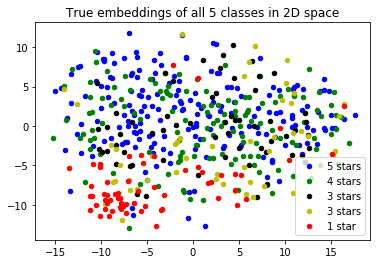

In [155]:
plt.scatter(x = results_df.loc[results_df['true_labels'] == 5].x_coord, 
            y = results_df.loc[results_df['true_labels'] == 5].y_coord, c='b', s=20, label='5 stars')
plt.scatter(x = results_df.loc[results_df['true_labels'] == 4].x_coord, 
            y = results_df.loc[results_df['true_labels'] == 4].y_coord, c='g', s=20, label='4 stars')
plt.scatter(x = results_df.loc[results_df['true_labels'] == 3].x_coord, 
            y = results_df.loc[results_df['true_labels'] == 3].y_coord, c='k', s=20, label='3 stars')
plt.scatter(x = results_df.loc[results_df['true_labels'] == 2].x_coord, 
            y = results_df.loc[results_df['true_labels'] == 2].y_coord, c='y', s=20, label='3 stars')
plt.scatter(x = results_df.loc[results_df['true_labels'] == 1].x_coord, 
            y = results_df.loc[results_df['true_labels'] == 1].y_coord, c='r', s=20, label='1 star')
plt.legend()
plt.title('True embeddings of all 5 classes in 2D space')
plt.show()

Due to the large number of features, the 2-D representation does not show clear boundaries between the classes. Charts below show the positioning of 5-star and 1-star classes (two classes that are the most different from each other). The MLPC model misclassifies between these two labels (true 5 predicted as 1, and true 1 predicted as 5) in <1% of cases. 

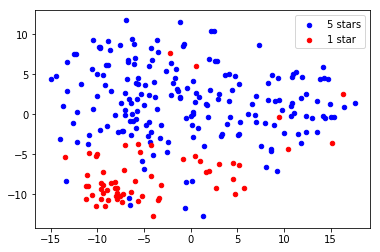

In [156]:
plt.scatter(x = results_df.loc[results_df['true_labels'] == 5].x_coord, 
            y = results_df.loc[results_df['true_labels'] == 5].y_coord, c='b', s=20, label='5 stars')

plt.scatter(x = results_df.loc[results_df['true_labels'] == 1].x_coord, 
            y = results_df.loc[results_df['true_labels'] == 1].y_coord, c='r', s=20, label='1 star')
plt.legend()
plt.show()

Looking at 5-star ratings only, we can visualise which points are correctly/falsely predicted by the MLPC model...

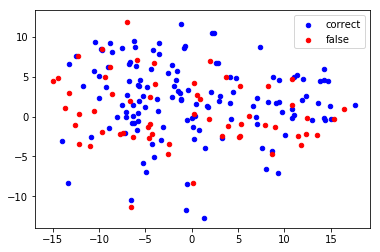

In [157]:
# 5-star correct and false predictions using MLPC
plt.scatter(x = results_df.loc[(results_df['true_labels'] == 5) & (results_df['mlpc_labels'] == 5)].x_coord, 
            y = results_df.loc[(results_df['true_labels'] == 5) & (results_df['mlpc_labels'] == 5)].y_coord, 
            c='b', s=20, label='correct')

plt.scatter(x = results_df.loc[(results_df['true_labels'] == 5) & (results_df['mlpc_labels'] != 5)].x_coord, 
            y = results_df.loc[(results_df['true_labels'] == 5) & (results_df['mlpc_labels'] != 5)].y_coord, 
            c='r', s=20, label='false')

plt.legend()
plt.show()

... and we can view the same results for 1-star ratings. The results seem to show that points on the fringes are corectly predicted, and the false ratings tend to fall in the middle of the chart, which is harder to distinguish from other classes.

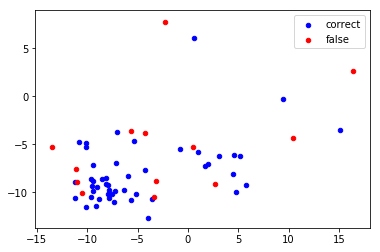

In [158]:
# 1-star correct and false predictions using MLPC
plt.scatter(x = results_df.loc[(results_df['true_labels'] == 1) & (results_df['mlpc_labels'] == 1)].x_coord, 
            y = results_df.loc[(results_df['true_labels'] == 1) & (results_df['mlpc_labels'] == 1)].y_coord, 
            c='b', s=20, label='correct')

plt.scatter(x = results_df.loc[(results_df['true_labels'] == 1) & (results_df['mlpc_labels'] != 1)].x_coord, 
            y = results_df.loc[(results_df['true_labels'] == 1) & (results_df['mlpc_labels'] != 1)].y_coord, 
            c='r', s=20, label='false')

plt.legend()
plt.show()

# 7. Conclusion 

We now have two methods for predicting the average Yelp rating for a restaurant:
1. Predicting the average rating based on a restaurant's features
2. Predicting the rating of each review based on the review text and averaging across all reviews written about the restaurant

The feature-based model is only able to give a general trend and provide a vague prediction that is marginally better than simply assuming that a restaurant will have a mena rating of 3.4 stars. The best model here was Gradient Boosting Regression (GBR), which provided a MSE of 0.5 stars, and a standard deviation of the prediction error of 0.68. 

The reviews-based model provides a better approximation. The MPL Regression algorithm gives a MSE of 0.57 on each individual review, and <0.1 when averaged over approx. 80 reviews per business. The standard deviation of prediction errors for a restaurant is 0.31 stars, which is a far more accurate and useful result.

From the business perspective, we can conclude that features do have an impact on ratings, and the most important features are location and opening hours (from feature importance of the GBR method). However, the subjective, human aspect of a restaurant, as captured by the reviews, is the more important factor in determining ratings. Hence the text-based predictive model can be used to analyze any text written about a restaurant and provide either a positive/negative sentiment judgement or predict a Yelp-style rating from 1 to 5 stars. 

Further, we have identified words that most commonly appear in the top-rated and bottom-rated reviews. By looking at the words that have the most discrepancy between to and bottom reviews, some high-level conclusions can be made:
- positive reviews are dominated by adjectives such as great/amazing/delicious (as expected), whereas negative reviews, aside from obvious words such as bad/not include more verbs (go/ask/get/order/take). It seems that negative reviews are often a narrative of what went wrong
- positive reviews tend to praise the quality of food and the atmosphere; negative reviews complain about waiting, ordering, seating, cold food and similar
- in terms of personnel, positive reviews commonly include the word 'owner', whereas negative reviews talk about the waiting staff and manager. Hence a dedicated owner is critical to top reviews, while poor service is responsible for bottom reviews
- pizza, breakfast, donut and  coffee are more common in top reviews; bottom reviews mention items such as drink, bar, chicken and burger 

The word2vec model can be visualized in 2D in order to identify the embedding of reviews by rating. However as the dimensionality reduction is very large (from 100 to 2 dimensions), the visualization does not provide a clear and easily interpretable classification. 